## Στοιχεία Ομάδας

Αριθμός Ομάδας: Μ.Α.11

    > Καρυπιάδης Ευστράτιος: 03114911

In [0]:
import warnings
warnings.filterwarnings('ignore')

---

## 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο

<img src="https://bit.ly/2RqHvGZ" width="85%">

---

### Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με περίπου 40.000 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset στο dataframe `df_data_1`: 

In [0]:
import pandas as pd

dataset_url = 'data/movieDBe.csv'
df_data_1 = pd.read_csv(dataset_url, sep='\t', header=None, quoting=3, error_bad_lines=False)

Θα δουλέψουμε σε ένα υποσύνολο 5.000 ταινιών ανάλογα με το seed της ομάδας μας:

In [0]:
import numpy as np

# Seed Number: 11
team_seed_number = 11

movie_seeds_url = 'data/seeds2019.csv'
df_data_2 = pd.read_csv(movie_seeds_url, header=None, error_bad_lines=False)

my_index = df_data_2.iloc[team_seed_number, :].values

titles = df_data_1.iloc[:, [2]].values[my_index]
categories = df_data_1.iloc[:, [3]].values[my_index]
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index]
summaries =  df_data_1.iloc[:, [5]].values[my_index] 
corpus = summaries[:, 0].tolist() # list form of summaries

- Ο πίνακας `titles` περιέχει τους τίτλους των ταινιών.

- O πίνακας `categories` περιέχει τις κατηγορίες της ταινίας υπό τη μορφή string. Παρατηρούμε ότι είναι μια comma-separated λίστα strings, με κάθε string να είναι μια κατηγορία.

- Ο πίνακας `catbins` περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή μέσω *One-Hot-Encoding*.

- Ο πίνακας `summaries` και η λίστα `corpus` περιλαμβάνουν τις συνόψεις των ταινιών με την corpus είναι ο πίνακας summaries σε μορφή λίστας. Κάθε σύνοψη είναι σε μορφή string.

- Θεωρούμε ως `id` της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας.

Στη συνέχεια της άσκησης θα υλοποιήσουμε ένα *Content Based Recommender System*.

---

### Μετατροπή σε TF - IDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψουμε το corpus σε αναπαράσταση *Term Frequency-Inverse Document Frequency (TF-IDF)*:

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

vectorizer.fit(corpus)
corpus_tf_idf = vectorizer.transform(corpus)

Σημειώνουμε πως η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ δεν είναι βελτιστοποιημένη.

In [13]:
corpus_tf_idf.shape

(5000, 48526)

---

### Υλοποίηση Συστήματος Συστάσεων

Θα δημιουργήσουμε τη συνάρτηση `content_recommender` με ορίσματα `target_movie` και `max_recommendations`. Πιο συγκεκριμένα, θα υπολογίζουμε για κάθε ταινία-στόχο την [ομοιότητα συνημιτόνου](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) από το `corpus_tf_idf` με όλες τις υπόλοιπες ταινίες, ενώ στη συνέχεια θα ταξινομούμε τις αντίστοιχες ομοιότητες ως προς το *index* της εκάστοτε ταινίας. Η συνάρτησή μας θα επιστρέφει το id, τον τίτλο, την κατηγορία και τη σύνοψη τόσο της ταινίας-στόχου, όσο και των `max_recommendations` συναφών ταινιών.

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

def content_recommender(target_movie, max_recommendations):
    """ Returns ID, Title, Genre and Summary of target_movie and #max_recommendation movies respectively. 
    Metric used: Cosine Similarity. """
    
    distances = np.zeros((corpus_tf_idf.shape[0]))
    for i in range(corpus_tf_idf.shape[0]):
        distances[i] = cosine_similarity(corpus_tf_idf[target_movie], corpus_tf_idf[i])
        
    distances_slices = np.argsort(distances) # ascending order of indexes
    distances_slices_descending = distances_slices[::-1]
    
    result = distances_slices_descending[:max_recommendations+1]
    
    for movie in result:
        yield("ID: " + str(movie) +" - Movie Title: " + titles[movie][0] + " - Genre: " + categories[movie][0] + "\n" + summaries[movie][0] + "\n\n")

Θα δοκιμάσουμε τη συνάρτηση στην ταινία [The Dog Who Saved Christmas](https://imdb.to/38BJZrZ):

In [15]:
for recommendation in content_recommender(3763, 5):
    print(recommendation)

ID: 3763 - Movie Title: The Dog Who Saved Christmas - Genre: "Family Film",  "Children's/Family",  "Comedy",  "Holiday Film",  "Television movie"
Zeus, a Labrador Retriever and a former police dog, has lost his bark after his barking ended up blowing off a five-year investigation and his partner can't shoot straight again and ends up at the pound. He is adopted by George Bannister as both an early Christmas present and as a good guard dog for the house, but the mom is hesitant and didn't want a dog. The dog is left alone on Christmas Eve when the family head off to visit Grandma's house. A pair of burglars, Ted Stein and Stewey McMann break into the family home, and it is up to Zeus to save Christmas for his new family by setting up booby traps to stop them. Zeus soon gets caught by the burglars and they muzzle him and continue to rob the house. Zeus escapes and gets them knocked out by dropping a chandelier on them. The police come and arrest Ted and Stewey and Zeus finally barks. The

Παρατηρούμε ότι το συστήμά μας δεν επιστρέφει πλήρως συναφείς ταινίες ως προς το βασικό περιεχόμενο της ταινίας-στόχου. Πιο συγκεκριμένα, φαίνεται πως για κάποιες ταινίες έχει στηριχτεί σε ονόματα χαρακτήρων, μία συμπεριφορά η οποία σε γενικές γραμμές δεν είναι επιθυμητή. Επίσης, αξίζει να σημειώσουμε και τη διαφοροποίηση που παρατηρείται σε σχέση με την κατηγορία της ταινίας εισόδου και εκείνων των προτεινόμενων επιλογών.

Στη συνέχεια θα προσπαθήσουμε να βελτιώσουμε το σύστημα συστάσεών μας προς διόρθωση των παραπάνω στοιχείων.

---

### Βελτιστοποίηση

Προς βελτίωση της συνάρτησης συστάσεων θα υλοποιήσουμε αρχικά τη συνάρτηση `custom_tokenizer`, σύμφωνα με την οποία ο `TfidfVectorizer` θα φτιάχνει το συνολικό λεξιλόγιο των δεδομένων μας. Πιο συγκεκριμένα θα δειγματοληπτεί το `corpus` της εκάστοτε ταινίας και θα αγνοεί τις λέξεις εκείνες που δεν αποτελούνται αποκλειστικά από γράμματα της αγγλικής αλφαβήτου. Θα επιστρέφει μία λίστα δειγμάτων, τα οποία όμως έχουν υποστεί [Stemming](#https://bit.ly/2Gk6W6L) μέσω του `PorterStemmer`.

In [0]:
import re
import nltk
from nltk.stem.snowball import PorterStemmer

nltk.download('punkt', quiet=True)

stemmer = PorterStemmer()

def custom_tokenizer(corpus):

  tokens = [word for sentence in nltk.word_tokenize(corpus) for word in nltk.word_tokenize(sentence)]
  valid_tokens = []
  for token in tokens:
        if re.search('[a-zA-Z]', token):
            valid_tokens.append(token)
  result = [stemmer.stem(t) for t in valid_tokens]

  return result

Σε ότι αφορά τη βελτιστοποίηση του `TfidfVectorizer` θα αγνοήσουμε αρχικά συχνά εμφανιζόμενους όρους που δε συμβάλλουν στη σκιαγράφηση του περιεχομένου μιας ταινίας, μέσω του ορίσματος `stop_words`. Επίσης, θα δοκιμάσουμε διαφορετικούς συνδυασμούς `min_df` και `max_df`, παρατηρώντας τόσο το αποτέλεσμα της συνάρτησής μας για συγκεκριμένες ταινίες, όσο και το παραγόμενο `vocabulary_`, από το οποίο σκοπός μας είναι να αφαιρέσουμε ουδέτερους, συχνά εμφανιζόμενους όρους.

In [218]:
import joblib

vectorizer = TfidfVectorizer(stop_words='english', max_df=0.35, min_df=125, tokenizer=custom_tokenizer)

%time corpus_tf_idf = vectorizer.fit_transform(corpus)

# Saving corpus_tf_idf
joblib.dump(corpus_tf_idf, 'corpus_tf_idf.pkl') 

CPU times: user 2min 15s, sys: 75.3 ms, total: 2min 15s
Wall time: 2min 15s


['corpus_tf_idf.pkl']

In [219]:
corpus_tf_idf.shape

(5000, 866)

Παρατηρούμε ότι η παραπάνω προσέγγιση μειώνει τα χαρακτηριστικά μας από περίπου 48.500 σε 866.

---

### Επεξήγηση Επιλογών, Ποιοτική Ερμηνεία και Παρατηρήσεις

Οι τιμές στις οποίες καταλήξαμε για τα ορίσματα `max_df` και `min_df` είναι 35% και 125, αντίστοιχα. Οδηγηθήκαμε σε αυτόν τον συνδυασμό τιμών, αφού πρώτα εξασφαλίσαμε την επιστροφή προτεινόμενων ταινιών με κοινό πυρήνα υπόθεσης ή περιβάλλοντος. Έπειτα, κινηθήκαμε σε γειτονικές περιοχές του διαστημάτος αυτού, με σκοπό τη βελτιστοποίηση των κατηγοριών που επιστρέφονται, οι οποίες προσπαθήσαμε να βρίσκονται όσο πιο κοντά γίνεται σε εκείνη της ταινίας-στόχου.

Στη συνέχεια παραθέτουμε 10 παραδείγματα ταινιών, για τις οποίες η συνάρτησή μας επιστρέφει ικανοποιητικά συναφή αποτελέσματα:

<br>

| Id | Movie Title | Θεματική |
| :---: | :---: | :---: |
| 53 | Five Fingers of Death | fight |
| 205 | They Live by Night  | bank |
| 428 | All About Love | love |
| 1098 | Hiroshima | war |
| 1263 | Live Evil | blood |
| 1504 | Rock 'n' Roll High School | school, student |
| 2081 | War of the Planets | crew |
| 3235 | Meatballs 4 | camp |
| 3763 | The Dog Who Saved Christmas | dog |
| 4699 | Jhanak Jhanak Payal Baje | dance | 

<br>

Αξίζει ωστόσο να σημειώσουμε ότι αν και το σύστημά μας επιστρέφει πράγματι συναφείς ως προς το περιεχόμενο ταινίες για τα παραπάνω παραδείγματα, δεν παρουσιάζει την ίδια επιθυμητή συμπεριφορά για όλο το σύνολο των δεδομένων μας. Επίσης, παρουσιάζει αδυναμίες σε ότι αφορά τις κατηγορίες των ταινιών, αφού είναι εντελώς εφικτό με είσοδο μία ταινία *Animation* να επιστρέψει ταινία *Horror*. 

Οι αδυναμίες του συστήματός μας θα μπορούσαν να οφείλονται στην ποιότητα του *dataset*, καθώς παρατηρούμε ότι αρκετές ταινίες χαρακτηρίζονται από σύντομες συνόψεις, οι οποίες δεν επιτρέπουν την επαρκή σκιαγράφηση της θεματικής τους ενότητας. Τέλος, είναι επίσης πιθανό κατά την βελτιστοποίηση του `TfidfVectorizer` είτε να αγνοήσαμε σημαντικά πολλούς όρους, είτε να χρειαζόταν να αφαιρέσουμε περισσότερους.

---

## 2. Τοπολογική και σημασιολογική απεικόνιση ταινιών με χρήση SOM

<img src="https://bit.ly/2Rs87HL" width="85%">

---

### Δημιουργία dataset

Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των [Self Organizing Maps-(SOM)](https://bit.ly/2ughnFu) για να φτιάξουμε ενά χάρτη δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους. 

Η συνάρτηση `build_final_set` αρχικά μετατρέπει την αραιή αναπαράσταση *TF-IDF* της εξόδου της `TfidfVectorizer()` σε πυκνή. Στη συνέχεια ενώνει την πυκνή `dense_tf_idf` αναπαράσταση και τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον χαρακτηριστικά. Συνεπώς, κάθε ταινία αναπαρίσταται στο *Vector Space Model* από τα χαρακτηριστικά του *TF-IDF* και τις κατηγορίες της. Σημειώνουμε ότι θα περάσουμε τα δεδομένα του `corpus_tf_idf` από τον [MinMaxScaler](#https://bit.ly/38CB612), καθώς αναμένουμε ότι κάτι τέτοιο θα βελτιώσει την απόδοση του νευρωνικού μας δικτύου.

In [0]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

def build_final_set(doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = corpus_tf_idf.toarray()[0:doc_limit, :]

    dense_tf_idf = scaler.fit_transform(dense_tf_idf)

    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the dense tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit, :]))
        # return data in float32 dtype: somoclu
    return np.array(final_set, dtype=np.float32)

In [0]:
final_set = build_final_set()

In [22]:
final_set.shape

(5000, 1188)

---

### Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη [Somoclu](https://bit.ly/361xnsk) και πιο συγκεκριμένα με χάρτη τύπου *planar* και παραλληλόγραμο σχήμα νευρώνων με τυχαία αρχικοποίηση. Το σχήμα νευρώνων που θα χρησιμοποιήσουμε είναι 30x30, ενώ στην εκπαίδευση θα επιλέξουμε 100 `epochs`.

Σημειώνουμε ότι προς μελλοντική εξοικονόμηση χρόνου και υπολογιστικής ισχύος θα αποθηκεύσουμε τον εκπαιδευμένο χάρτη.

In [24]:
import somoclu

rows, columns = 30, 30 
som = somoclu.Somoclu(columns, rows, kerneltype=1, compactsupport=False)

%time som.train(data=final_set, epochs=100)

# Saving trained SOM 
joblib.dump(som, 'som.pkl')

CPU times: user 1h 1min 44s, sys: 4.51 s, total: 1h 1min 49s
Wall time: 31min 17s


['som.pkl']

---

### Best Matching Units

Στη συνέχεια θα αποθηκεύσουμε τα μοναδικά *Best Matching Units* και τους αντίστοιχους δείκτες τους στις ταινίες με χρήση της [np.unique](https://bit.ly/2RtVFGd).

Σημειώνουμε ότι θα μετατρέψουμε τον πίνακα `bmus_uniq` σε λίστα από *tuples*, ένας μετασχηματισμός που θα μας χρησιμεύσει σε επόμενη αντιστοίχιση των bmus με τους νευρώνες. 

In [0]:
bmus = som.bmus

bmus_uniq, bmus_indices = np.unique(bmus, axis=0, return_inverse=True)
bmus_uniq = list(map(tuple, bmus_uniq)) # ndarray to list of tuples

In [26]:
len(bmus_uniq)

705

Παρατηρούμε ότι τα *bmus* είναι μικρότερα από το πλήθος των νευρώνων που επιλέξαμε, καθώς σε 195 από αυτούς δεν ανατέθηκε κάποια ταινία.

---

### Οπτικοποίηση U-matrix, Clustering και Μέγεθος Clusters

Προς οπτικοποίηση του *U-matrix* θα χρησιμοποιήσουμε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά *clusters* που προκύπτουν από τον [K-Means](https://bit.ly/2R7TM2Z), τον αλγόριθμο που επιλέξαμε για την ομαδοποίηση των νευρώνων. Επιλέγουμε `k=40`, προσπαθώντας να προσεγγίσουμε τις διακριτές περιοχές που φαίνονται στη γραφική μας αναπαράσταση.

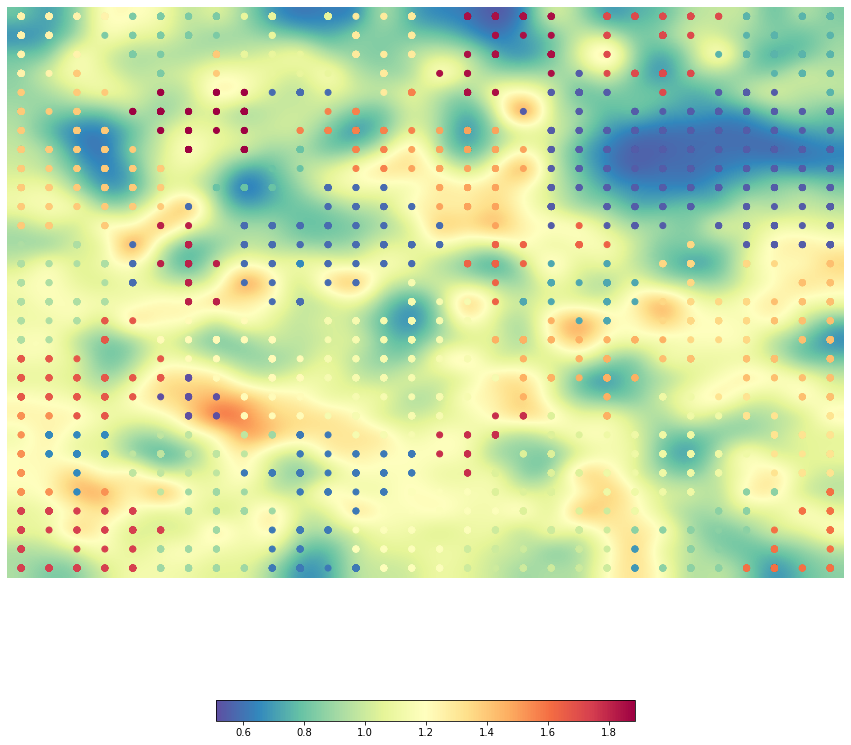

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [135]:
import matplotlib
from matplotlib import cm
from sklearn.cluster import KMeans

%matplotlib inline

clustering = KMeans(n_clusters=40)
som.cluster(algorithm=clustering)

som.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

Για μια δεύτερη και πιο ξεκάθαρη οπτικοποίηση του *clustering* θα τυπώσουμε απευθείας τη μεταβλητή `som.clusters`. Για αισθητικούς λόγους θα μετατρέψουμε τον δισδιάστατο πίνακα σε *DataFrame*, καθώς το πλήθος των νευρώνων δεν επιτρέπει στοιχισμένη απεικόνιση:

In [136]:
acc = [i for i in range(1, 31)]

clust_df = pd.DataFrame(som.clusters, columns=acc, index=acc)
clust_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
1,21,21,21,21,9,9,9,9,16,16,16,16,22,22,22,38,38,38,38,38,34,34,34,34,34,34,7,7,7,7
2,21,21,21,9,9,9,9,9,16,16,16,22,22,22,22,22,38,38,38,38,34,34,34,34,34,34,7,7,7,7
3,21,21,21,9,9,9,9,25,16,16,16,22,22,22,22,22,38,38,38,38,38,34,34,34,34,7,7,7,7,7
4,21,21,25,25,9,9,9,25,16,16,16,16,22,22,22,38,38,38,38,38,1,34,34,34,34,1,7,7,7,7
5,25,25,25,25,39,39,39,39,39,2,2,2,30,22,30,38,38,38,1,1,1,1,34,34,1,1,1,1,7,7
6,25,25,25,25,39,39,39,39,39,39,2,30,30,30,30,28,28,28,1,1,1,1,1,1,1,1,1,1,1,1
7,25,25,25,25,25,39,39,39,39,39,30,30,30,30,30,28,28,28,1,1,1,1,1,1,1,1,1,1,1,1
8,25,25,25,25,25,25,39,39,39,8,8,30,30,30,28,28,28,28,28,1,1,1,1,1,1,1,1,1,1,1
9,25,25,25,25,25,25,25,8,8,8,8,2,30,30,28,28,28,28,28,1,1,1,1,1,1,1,1,1,1,1
10,25,25,25,25,25,25,8,8,8,8,8,2,2,2,28,28,28,28,1,1,1,1,1,1,1,1,1,1,1,1


Τέλος, θα εμφανίσουμε τις ετικέτες των *clusters* με αύξουσα σειρά ως προς τον αριθμό των νευρώνων:

In [157]:
cluster_vals, cluster_counts = np.unique(som.clusters, return_counts=True)
x = dict(zip(cluster_vals, cluster_counts))

l1, l2 = [], []

a = {k: v for k, v in sorted(x.items(), key=lambda x: x[1])}
for key, value in a.items():
  l1.append(key)
  l2.append(value)

final_frame = pd.DataFrame(np.vstack((np.array(l1), np.array(l2))), columns=[i for i in range(1, 41)], index = ["Cluster Index", "Number of Neurons"])
final_frame

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
Cluster Index,5,0,4,29,36,21,8,16,31,32,6,13,37,9,30,10,15,22,23,14,7,39,11,19,12,35,34,38,24,28,33,20,27,17,26,3,25,18,2,1
Number of Neurons,2,7,10,10,11,12,14,14,14,14,15,15,15,16,16,17,17,17,17,18,19,19,20,20,21,21,22,22,24,25,25,26,29,30,30,33,47,48,53,95


---

### Σημασιολογική Ερμηνεία των Clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του *SOM* και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης με το *TF-IDF* και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των *clusters*. Για αυτό το σκοπό θα υλοποιήσουμε τη συνάρτηση `fetch_cluster_neuron_movie_report`, η οποία θα δέχεται σαν όρισμα τον αριθμό ενός *cluster* και θα επιστρέφει με φθίνουσα σειρά τις κατηγορίες ταινιών που συνθέτουν τη συγκεκριμένη ομάδα, συνοδευόμενες από το αντίστοιχο πλήθος.

In [0]:
def fetch_categories_stats(id_list):
  """ Receives id_list as input corresponding to movie index, returns frequency of movie categories in descending order. """

  acc_l = []
  for id in id_list:
    curr = [cat.strip().strip('\"') for cat in categories[id][0].split(',')] # strip spaces, quotes
    acc_l.extend(curr)
  acc = np.asarray(acc_l)
  unique, counts = np.unique(acc, return_counts=True)
  result = []
  for i in np.argsort(counts)[::-1]:
    result.append((unique[i], counts[i]))
  return result

def neuron_movies_report(neuron_list):
  """ Receives index of neuron and returns its category statisticsm by calling fetch_categories_stats. """

  acc = []
  for index in neuron_list:
    acc.append(bmus_indices[index])
  result = fetch_categories_stats(acc)
  return result

def fetch_cluster_neurons_movie_report(cluster_id):
  """ Receives a cluster_id as input, returns count of categories belonging to the cluster given. """

  acc = []
  curr =  np.column_stack((np.where(som.clusters==cluster_id)[1], np.where(som.clusters==cluster_id)[0]))
  curr = list(map(tuple, curr)) # ndarray to list of tuples
  for pair in curr: # check if coordinates belong to bmus_uniq
    if pair in bmus_uniq:
      acc.append(bmus_uniq.index(pair))
  result = neuron_movies_report(acc)
  return result

---

### Ανάλυση Τοπολογικών Ιδιοτήτων του SOM


Θα αναλύσουμε αρχικά τις ιδιότητες του SOM αποδεικνύοντας ότι κατηγορίες με μεγαλύτερη πυκνότητα πιθανότητας στα δεδομένα εισόδου τείνουν να αντιστοιχίζονται και σε περισσότερους νευρώνες. Θα συνθέσουμε τα αντίστοιχα στατιστικά στοιχεία στο συνολικό `cat_frame`.

In [212]:
# count all categories for every movie
cat_acc = {}
for movie in categories:
  curr = [cat.strip().strip('\"') for cat in movie[0].split(',')]
  for curr_cat in curr:
    if curr_cat in cat_acc:
      cat_acc[curr_cat] += 1
    else:
      cat_acc[curr_cat] = 1

# category percentagies for dataset
stats_cat = {}
for key, value in cat_acc.items():
  stats_cat[key] = round(value/5000 * 100, 2)

# category sorting
final_cat = []
for key, value in stats_cat.items():
  final_cat.append((key, value))
final_cat.sort(key=lambda tup: tup[1])

# count neurons for every category
total_neurons = {}
for i in range(40):
  for cat in fetch_cluster_neurons_movie_report(i):
    if cat[0] in total_neurons:
      total_neurons[cat[0]] += cat[1]
    else:
      total_neurons[cat[0]] = 1

# final dataframe
temp = []
for pair in final_cat[::-1]:
  if pair[0] in total_neurons:
    temp.append([pair[0], pair[1], total_neurons[pair[0]]])
  else:
    temp.append([pair[0], pair[1], None]) # no neuron assigned

cat_frame = pd.DataFrame(temp, columns=['Genre', 'Percentage', 'Neurons'], index = [i for i in range(1, 270)])
cat_frame.head(10)

,Genre,Percentage,Neurons
1,Drama,45.98,311.0
2,Comedy,24.24,162.0
3,Romance Film,16.18,101.0
4,Thriller,15.92,138.0
5,Action,14.40,116.0
6,World cinema,11.88,93.0
7,Crime Fiction,10.42,85.0
8,Horror,9.40,51.0
9,Action/Adventure,9.06,77.0
10,Black-and-white,8.68,57.0


Παρατηρώντας τα πρώτα 10 στοιχεία του παραπάνω *DataFrame*, διαπιστώνουμε ότι πράγματι φαίνεται η τάση οι συχνότερες κατηγορίες να αντιστιχοίζονται σε μεγαλύτερο πλήθος νευρώνων, χωρίς ωστόσο αυτό να αποτελεί κανόνα για τα δεδομένα μας.

Συνεχίζουμε με την εμφάνιση των βασικότερων κατηγοριών για κάθε ένα *cluster* μέσω της συνάρτησης `fetch_cluster_neuron_movie_report`:

In [217]:
for i in range(40):
  print(str(i) + " " + str(fetch_cluster_neurons_movie_report(i)))

0 [('Drama', 4), ('World cinema', 2), ('Thriller', 2), ('Black-and-white', 2), ('Action/Adventure', 2), ('Western', 1), ('Romance Film', 1), ('Period piece', 1), ('Japanese Movies', 1), ('Film noir', 1), ('Crime Thriller', 1), ('Crime Fiction', 1), ('Comedy', 1), ('B-Western', 1), ('Art film', 1), ('Action', 1)]
1 [('Drama', 36), ('Comedy', 21), ('Action', 19), ('Thriller', 15), ('Romance Film', 14), ('World cinema', 11), ('Horror', 10), ('Indie', 9), ('Crime Fiction', 9), ('Action/Adventure', 9), ('Adventure', 7), ('Romantic drama', 6), ('Black-and-white', 6), ('Romantic comedy', 5), ('Musical', 5), ('Short Film', 4), ('Science Fiction', 4), ('Television movie', 4), ('Bollywood', 4), ('Family Film', 4), ('Mystery', 4), ('Teen', 4), ('Chinese Movies', 3), ('Western', 3), ('Japanese Movies', 3), ('Comedy-drama', 3), ('Crime Thriller', 3), ('Fantasy', 3), ('Comedy film', 2), ('Suspense', 2), ("Children's/Family", 2), ('Slasher', 2), ('Black comedy', 2), ('Silent film', 2), ('Period piece

Μελετώντας την έξοδο της παραπάνω συνάρτησης σε συνδυασμό με την τοπολογικη αναπαράσταση του SOM μπορούμε να παρατηρήσουμε τα εξής:

- Η κατηγορία **Thriller** μπορεί να αποδοθεί στα cluster 1, 2 με 15 και 12 ταινίες, αντίστοιχα. Παρατηρούμε ότι το cluster 38 θα μπορούσε να θεωρηθεί ως cluster **Crime Thriller** και πράγματι συνορεύει με το cluster 1. Επίσης, εάν θεωρήσουμε πως στο cluster 28 συσσωρεύονται ταινίες κατηγορίας **Psychological Thriller**, είναι αναμενόμενο που συνορεύει με τα cluster 1 και 2.

- Η κατηγορία **Romance** μπορεί να αποδοθεί στα cluster 1, 2 και 18 με 14, 8 και 7 ταινίες, αντίστοιχα. Παρατηρούμε ότι τα cluster 24 και 27, αντιστοιχούν στην κατηγορία **Romantic Comedy** και πράγματι συνορεύουν με τα cluster 18 και 1, αντίστοιχα. Ακόμη, το cluster της κατηγορίας **Romantic Drama** με αριθμό 6, συνορεύει με τα βασικά cluster 1 και 2.

- Η κατηγορία **Action** μπορεί να αποδοθεί στα cluster 1, 15 με 19 και 5 ταινίες, αντίστοιχα. Αντίστοιχα cluster της κατηγορίας **Action/Adventure** με αριθμούς 3 και 28 συνορεύουν με τα cluster 15 και 1, αντίστοιχα. Αξίζει, ωστόσο, να παρατηρήσουμε ότι το cluster 21, το οποίο παρουσιάζει αξιοσημείωτο πλήθος action/adventure ταινιών είναι τοποθετημένο στη μακρύτερη δυνατή απόσταση και από τα δύο βασικά μας cluster.

- Η κατηγορία **Horror** μπορεί να αποδοθεί στα cluster 1 και 18, ενώ εκείνη της **Animation** στα cluster 3, 12, 24 και 25. Αναμένουμε οι δύο αυτές κατηγορίες να βρίσκονται σε απομονωμένα σημεία του χάρτη, υπόθεση η οποία επιβεβαιώνεται εάν παρατηρήσουμε τα απομακρυσμένα cluster 1-18 με τα 12-24. Παρόλα αυτά δεν συμβαίνει το ίδιο για τα cluster 3, 25 τα οποία ερμηνεύουμε ως μη επιθυμητή συμπεριφορά.

Τέλος, αξίζει να παρατηρήσουμε ότι το cluster 4 έχει ιδιαίτερο ενδιαφέρον για το dataset μας, καθώς χαρακτηρίζεται από το πλέον εντονότερο κόκκινο χρώμα στο χάρτη μας. Μελετώντας τις κατηγορίες που του έχουν αντιστοιχιθεί, διαπιστώνουμε ότι αποτελείται από μία ποικιλία διαφορετικών μεταξύ τους ταινιών, όπως για παράδειγμα **Film Noir**, **Animation**, **Western** και **Chinese Movies**.

---

### Παρατηρήσεις

Γενικά εάν και στον χάρτη έχουν σχηματιστεί σχετικά διακριτά clusters, καθίσταται δύσκολος ο επακριβής διαχωρισμός των ταινίων. Αυτό οφείλεται κυρίως στο γεγονός ότι αρκετές συνόψεις δε σκιαγραφούν επαρκώς το σενάριο και περιεχόμενο των αντίστοιχων ταινιών που συνοδεύουν, με αποτέλεσμα να μην μπορούν να αναπαρασταθούν ακριβώς στο *Vector Matrix*. Επίσης, ένας ακόμη παράγοντας που δυσχεραίνει την ομαδοποίηση των ταινιών μας είναι το μεγάλο πλήθος κατηγοριών από τις οποίες χαρακτηρίζονται αρκετές ταινίες.

Αποτέλεσμα όλων των παραπάνω είναι ο SOM να ομαδοποιεί αξιοπρεπώς μεγάλο μέρος των δεδομένω μας, χωρίς όμως αυτό να μπορεί να γενικευθεί στο γενικό σύνολο.